# Research question 8.

## Do sequels or franchise movies follow different patterns in their endings compared to standalone films? 

Investigating whether franchise movies are more likely to have open-ended or happy endings to encourage future installments could reveal a unique trend in storytelling within cinematic universes.

##### Importations

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

In [ ]:
# path
DATA_FOLDER = '../../src/data/'
MOVIE_DATASET = DATA_FOLDER + 'movies_dataset_cleaned_with_director_vote_revenue_collection.tsv'

# Dataset loading
movies = pd.read_csv(MOVIE_DATASET, sep='\t')

In [39]:
movies.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie runtime,Movie languages (Freebase ID:name tuples),Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),Release year,Movie genres,Movie languages,Movie countries,Score,director,vote_average,revenue,collection
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,"Thriller, Science Fiction, Horror, Adventure, ...",English Language,United States of America,3.0,John Carpenter,5.1,14010832.0,NaN
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,"Mystery, Biographical film, Drama, Crime Drama",English Language,United States of America,5.0,Edward Lucas,8.0,0.0,NaN
2,13696889,/m/03cfc81,The Gangsters,1913-05-29,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,"Short Film, Silent film, Indie, Black-and-whit...","Silent film, English Language",United States of America,3.0,Henry Lehrman,6.0,0.0,NaN
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,"Musical, Comedy, Black-and-white",English Language,United States of America,4.0,Henry King,6.6,4000000.0,NaN
4,6631279,/m/0gffwj,Little city,1997-04-04,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...",1997,"Romantic comedy, Ensemble Film, Comedy-drama, ...",English Language,United States of America,4.0,Hervé Palud,6.0,0.0,NaN


Since films belonging to a collection have a collection number, while standalone films are labeled as 'NaN,' we created a binary column where '1' marks films in a collection and '0' marks standalone films.

In [40]:
# create a binary column indicating if the movie belongs to a collection
movies['in_collection'] = movies['collection'].notna().astype(int)
movies.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie runtime,Movie languages (Freebase ID:name tuples),Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),Release year,Movie genres,Movie languages,Movie countries,Score,director,vote_average,revenue,collection,in_collection
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,"Thriller, Science Fiction, Horror, Adventure, ...",English Language,United States of America,3.0,John Carpenter,5.1,14010832.0,NaN,0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,"Mystery, Biographical film, Drama, Crime Drama",English Language,United States of America,5.0,Edward Lucas,8.0,0.0,NaN,0
2,13696889,/m/03cfc81,The Gangsters,1913-05-29,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,"Short Film, Silent film, Indie, Black-and-whit...","Silent film, English Language",United States of America,3.0,Henry Lehrman,6.0,0.0,NaN,0
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,"Musical, Comedy, Black-and-white",English Language,United States of America,4.0,Henry King,6.6,4000000.0,NaN,0
4,6631279,/m/0gffwj,Little city,1997-04-04,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...",1997,"Romantic comedy, Ensemble Film, Comedy-drama, ...",English Language,United States of America,4.0,Hervé Palud,6.0,0.0,NaN,0


#### Statistics

In [41]:
# calculate mean between groups
mean_scores = movies.groupby('in_collection')['Score'].mean()

#printing
print(f"\n{'-'*40}")
print("Average Scores for Standalone vs. Collection Movies")
print(f"{'-'*40}")
print(f"{'Standalone Movies (0)':<25}: {mean_scores[0]}")
print(f"{'Collection Movies (1)':<25}: {mean_scores[1]}")
print(f"{'-'*40}")


----------------------------------------
Average Scores for Standalone vs. Collection Movies
----------------------------------------
Standalone Movies (0)    : 3.190711716341213
Collection Movies (1)    : 3.189189189189189
----------------------------------------



Quantiles for Standalone and Collection Movies
Quantile   Standalone (0)       Collection (1)
----------------------------------------
25th Percentile: 3.0                  3.0
50th Percentile: 3.0                  3.0
75th Percentile: 4.0                  4.0


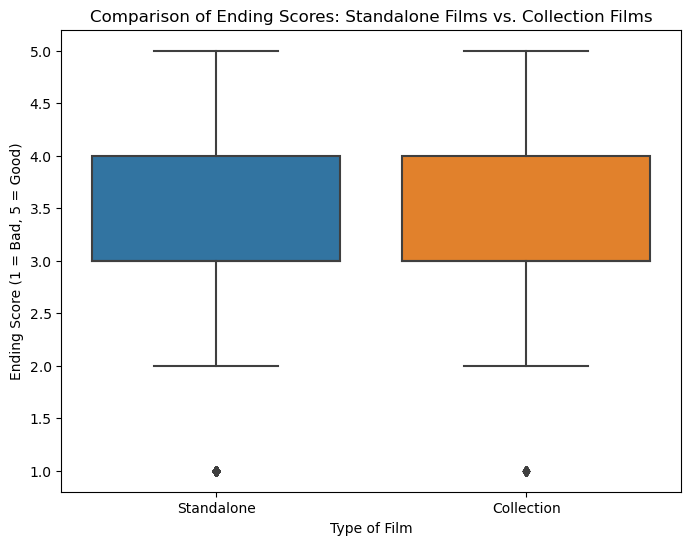

In [45]:
# Quantile for each group 
quantiles = movies.groupby('in_collection')['Score'].quantile([0.25, 0.5, 0.75]).unstack()
quantiles = quantiles.round(2)

# printing
print("\n" + "="*40)
print("Quantiles for Standalone and Collection Movies")
print("="*40)
print(f"{'Quantile':<10} {'Standalone (0)':<20} {'Collection (1)'}")
print("-"*40)

for quantile in [0.25, 0.5, 0.75]:
    print(f"{quantile*100:.0f}th Percentile: {quantiles[quantile][0]:<20} {quantiles[quantile][1]}")

print("="*40)

# Boxplot of score according to the collection belonging 
plt.figure(figsize=(8, 6))
sns.boxplot(data=movies, x='in_collection', y='Score')
plt.xticks([0, 1], ['Standalone', 'Collection'])
plt.xlabel('Type of Film')
plt.ylabel('Ending Score (-1 = Bad, +1 = Good)')
plt.title('Comparison of Ending Scores: Standalone Films vs. Collection Films')
plt.show()


#### The goal of this code is to perform a statistical test (t-test) to compare the ending scores between two groups of movies: those that belong to a collection (franchise or series) and those that are standalone films.

 The t-test helps us assess whether there is a statistically significant difference in the mean ending scores between franchise (collection) films and standalone films. If the p-value is less than 0.05, it would indicate that the difference in scores is statistically significant, implying that the type of film (franchise vs. standalone) could influence the ending scores.
 
We use an independent t-test because it is designed to compare the means of two independent groups (franchise vs. standalone films) to determine if there is a statistically significant difference in their ending scores, which is more appropriate than tests like paired t-tests or ANOVA for this type of data structure.

In [47]:
# Filter the movies DataFrame to get scores for movies in a collection (franchise or series)
scores_collection = movies[movies['in_collection'] == 1]['Score']

# Filter the movies DataFrame to get scores for standalone movies (not in a collection)
scores_standalone = movies[movies['in_collection'] == 0]['Score']

# Perform an independent t-test to compare the mean scores of the two groups
# The 'nan_policy="omit"' ensures that any NaN values are excluded from the test
t_stat, p_value = ttest_ind(scores_collection, scores_standalone, nan_policy='omit')

# Print the t-statistic and p-value
# The t-statistic tells us the magnitude of the difference between the groups
# The p-value helps us determine if the difference is statistically significant
print(f"\nT-statistic: {t_stat:.2f}, p-value: {p_value:.4f}")

# Check if the p-value is less than 0.05 to determine if the difference is statistically significant
if p_value < 0.05:
    print("\nThe difference between franchise and standalone films' ending scores is statistically significant.")
else:
    print("\nThere is no statistically significant difference between franchise and standalone films' ending scores.")



T-statistic: -0.08, p-value: 0.9355

There is no statistically significant difference between franchise and standalone films' ending scores.


#### Counting and visualizing the distribution of standalone vs. collection films


Distribution of Movies by Type:
Standalone Films: 35111
Collection Films: 4261


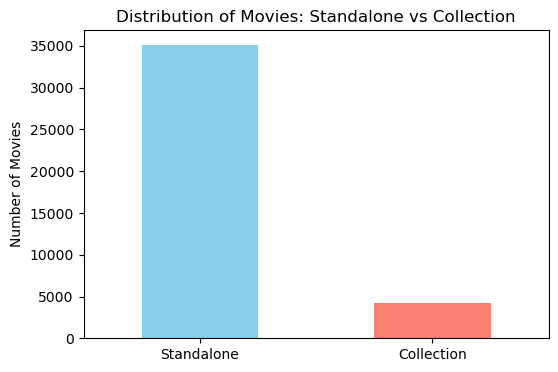

In [48]:
# Count the number of films in each group: 'Collection' and 'Standalone'
group_counts = movies['in_collection'].value_counts()

# Print the group counts with a clearer message
print("\nDistribution of Movies by Type:")
print("="*40)
print(f"Standalone Films: {group_counts.get(0, 0)}")
print(f"Collection Films: {group_counts.get(1, 0)}")
print("="*40)

# Visualization to display the balance between the two groups
import matplotlib.pyplot as plt

# Create a bar plot to show the distribution of standalone vs. collection films
plt.figure(figsize=(6, 4))
group_counts.plot(kind='bar', color=['skyblue', 'salmon'])

# Customize the plot for better readability
plt.xticks([0, 1], ['Standalone', 'Collection'], rotation=0)
plt.ylabel('Number of Movies')
plt.title('Distribution of Movies: Standalone vs Collection')

# Display the plot
plt.show()


We use undersampling here because it helps to create a balanced dataset, where both groups (standalone and collection films) have an equal number of films. This is important for ensuring that the analysis isn't biased toward the more frequent group. We could have also used oversampling, but undersampling is chosen here to avoid artificially inflating the number of data points in the smaller group, which could lead to overfitting


New distribution of movies after undersampling:
0    4261
1    4261
Name: in_collection, dtype: int64


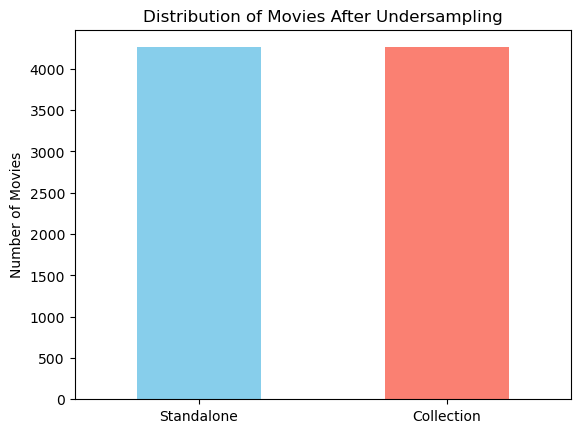

In [49]:
# Undersampling: Keep an equal number of standalone and collection films

# Filter movies that belong to a collection (franchise or series)
collection_movies = movies[movies['in_collection'] == 1]

# Filter movies that are standalone (not in any collection)
standalone_movies = movies[movies['in_collection'] == 0]

# Undersample the standalone films to match the number of collection films
standalone_movies_resampled = standalone_movies.sample(n=group_counts[1], random_state=42)

# Combine the undersampled standalone films with the collection films
movies_resampled = pd.concat([collection_movies, standalone_movies_resampled])

# Check the new distribution of the dataset after undersampling
print("\nNew distribution of movies after undersampling:")
print("="*40)
print(movies_resampled['in_collection'].value_counts())
print("="*40)

# Visualization of the distribution after undersampling
movies_resampled['in_collection'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.xticks([0, 1], ['Standalone', 'Collection'], rotation=0)
plt.ylabel('Number of Movies')
plt.title('Distribution of Movies After Undersampling')
plt.show()



Average Scores for Standalone vs Collection Movies (After Undersampling):
Standalone Films: 3.1778364116094986
Collection Films: 3.189189189189189


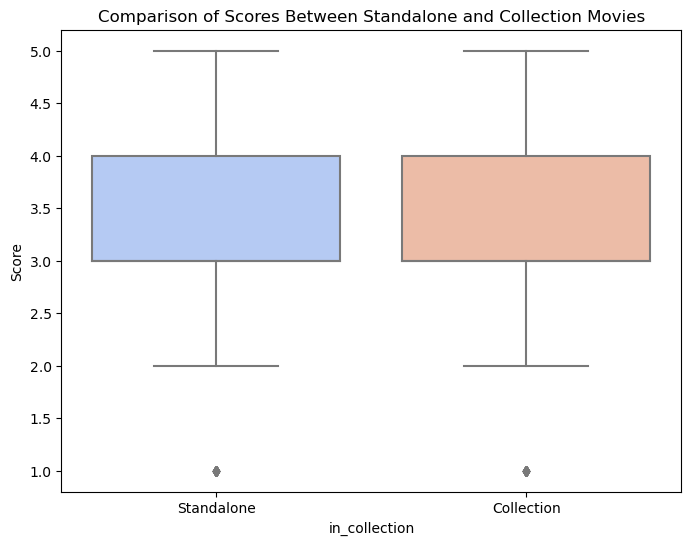

In [51]:
# Comparison of the average scores between collection films and standalone films after undersampling

# Calculate the mean score for each group (Standalone and Collection films)
mean_scores_resampled = movies_resampled.groupby('in_collection')['Score'].mean()

# Print the mean scores with a more informative message
print("\nAverage Scores for Standalone vs Collection Movies (After Undersampling):")
print("="*60)
print(f"Standalone Films: {mean_scores_resampled.get(0, 'N/A')}")
print(f"Collection Films: {mean_scores_resampled.get(1, 'N/A')}")
print("="*60)

# Visualizing the distribution of scores between the two groups
plt.figure(figsize=(8, 6))

# Create a boxplot to compare the score distributions
sns.boxplot(x='in_collection', y='Score', data=movies_resampled, palette='coolwarm')

# Customize the plot for better readability
plt.xticks([0, 1], ['Standalone', 'Collection'], rotation=0)
plt.ylabel('Score')
plt.title('Comparison of Scores Between Standalone and Collection Movies')

# Display the plot
plt.show()


In [52]:

# Separate the scores of collection films and standalone films after resampling
scores_collection_resampled = movies_resampled[movies_resampled['in_collection'] == 1]['Score']
scores_standalone_resampled = movies_resampled[movies_resampled['in_collection'] == 0]['Score']

# Perform a t-test to compare the scores between the two groups (collection vs. standalone)
t_stat_resampled, p_value_resampled = ttest_ind(scores_collection_resampled, scores_standalone_resampled, nan_policy='omit')

# Print the results with more informative formatting
print("\nT-test Results Comparing Scores Between Standalone and Collection Movies (After Undersampling):")
print("="*70)
print(f"T-statistic (Resampled Data): {t_stat_resampled:.4f}")
print(f"P-value (Resampled Data): {p_value_resampled:.4f}")
print("="*70)

# Interpretation of the results
if p_value_resampled < 0.05:
    print("The difference in scores between Standalone and Collection films is statistically significant.")
else:
    print("The difference in scores between Standalone and Collection films is not statistically significant.")



T-test Results Comparing Scores Between Standalone and Collection Movies (After Undersampling):
T-statistic (Resampled Data): 0.4552
P-value (Resampled Data): 0.6490
The difference in scores between Standalone and Collection films is not statistically significant.



Average Scores by Release Year (Standalone vs Collection Films):
in_collection         0         1
Release year                     
1895                NaN       NaN
1896           4.000000       NaN
1897                NaN       NaN
1898           3.000000       NaN
1900           3.000000       NaN
...                 ...       ...
2011           3.162162  3.202381
2012           3.250000  3.366667
2013           3.000000  3.250000
2014           4.000000       NaN
2016                NaN  2.500000

[116 rows x 2 columns]


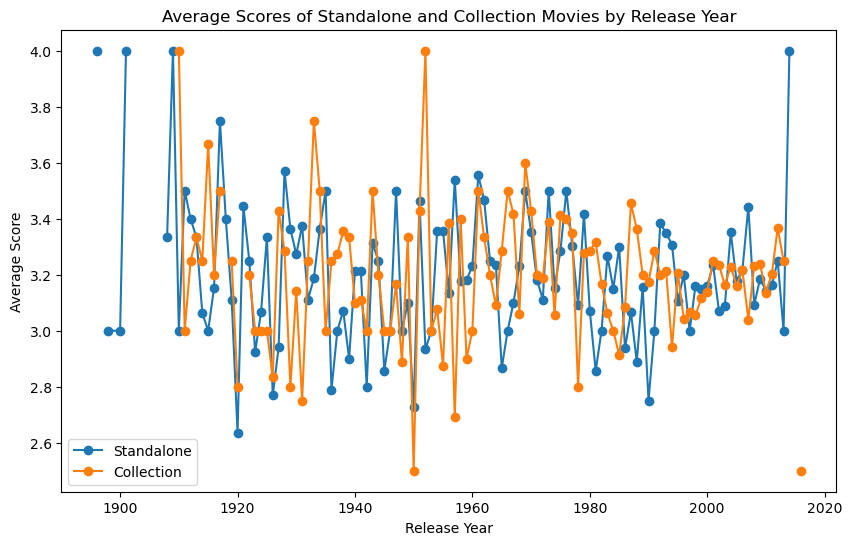

In [53]:
# Calculate the average scores by release year for both standalone and collection films
scores_by_year = movies_resampled.groupby(['Release year', 'in_collection'])['Score'].mean().unstack()

# Print the calculated average scores for each year
print("\nAverage Scores by Release Year (Standalone vs Collection Films):")
print("="*70)
print(scores_by_year)
print("="*70)

# Visualize the average scores over the years for both groups
scores_by_year.plot(kind='line', figsize=(10, 6), marker='o')

# Customize the plot for better readability
plt.xlabel('Release Year')
plt.ylabel('Average Score')
plt.title('Average Scores of Standalone and Collection Movies by Release Year')
plt.legend(['Standalone', 'Collection'])

# Display the plot
plt.show()